In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix

In [3]:
# read in data

data = pd.read_csv('./data/reddit_working_cleaned.csv')

In [4]:
# set display
# increase column widht to see the whole length of a text in the documents

pd.set_option('display.max_colwidth', 500)

In [5]:
# create is_science column
# assign value 1 to askscience
# assign value 0 to scifi

data['is_science'] = data['subreddit'].map({'askscience': 1, 'scifi': 0})

In [6]:
# check for missing data

data = data.loc[data['selftext'].notna()]

In [7]:
data.shape

(48011, 5)

In [8]:
data['subreddit'].value_counts(normalize=True)

askscience    0.504093
scifi         0.495907
Name: subreddit, dtype: float64

In [10]:
# set features and y variables

X = data['selftext']
y = data['is_science']

# train_test_split the data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y
                                                    )

In [11]:
# create function that instantiates pipeline
# arguments: transformer, estimator

def piper(transformer, estimator):
    pipe = make_pipeline(transformer, estimator)
    return pipe

In [12]:
# define transformer parameters for gridsearch

def transformer_params(transformer):
    transf = str(transformer).split('(')[0].lower()
    params = {
        transf + '__max_features': [10_000],
        transf + '__stop_words': [None],
        transf + '__ngram_range': [(1, 1)]
    }
    return params

In [13]:
# define estimator parameters for gridsearch

def estimator_params(estimator):
    est = str(estimator).split('(')[0].lower()
    params = {
        est + '__C': [1.85]
    }
    return params

In [14]:
# create function: arguments = pipeline, params
# runs gridsearch cv
# gives back: gridsearch cv score, best parameters

def gridsearch(transformer, estimator):

    pipe = piper(transformer, estimator)
    params = {**transformer_params(transformer),\
              **estimator_params(estimator)}
    # https://thispointer.com/how-to-merge-two-or-more-dictionaries-in-python/
    gs = GridSearchCV(pipe,
                      param_grid=params,
                      cv=5,
                      n_jobs=-1)
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_
    
    print(str(transformer).split('(')[0])
    print('')
    print('Best model:', best_model)
    print('')
    print('Cross-val score of the best model:', gs.best_score_)
    print('Accuracy of best model on the training data:', best_model.score(X_train, y_train))
    print('Accuracy of best model on the testing data:', best_model.score(X_test, y_test))
    print('')
    print('')

#### Best Model

**Best parameters:**
<br> Tfidf-Vectorizer:<br>
    - max_features: 10_000 <br>
    - stop_words: None <br>
    - ngram_range: (1, 1) <br>
<br> Logistic Regression: <br>
    - C = 1.85

In [15]:
gridsearch(TfidfVectorizer(), LogisticRegression())

TfidfVectorizer

Best model: Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.85, class_weight=None, dual=False,
                 

#### Evaluate Best Model

**Confusion Matrix**

In [17]:
best_pipe = make_pipeline(TfidfVectorizer(max_features=10_000),
                          LogisticRegression(C=1.85))
best_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.85, class_weight=None, dual=False,
                                    fit_interc

In [18]:
# create predictions from test data - based on model fit on training data

preds = best_pipe.predict(X_test)

In [19]:
# create confusion matrix 

conf_matrix = confusion_matrix(y_test, preds)
conf_matrix

array([[5541,  411],
       [ 210, 5841]])

In [20]:
# unpack confusion matrix

tn, fp, fn, tp = conf_matrix.ravel()

In [21]:
# create confusion dataframe

pd.DataFrame(conf_matrix, index=['actual scifi', 'actual science'], 
                 columns=['predicted scifi', 'predicted science'])

,predicted scifi,predicted science
actual scifi,5541,411
actual science,210,5841


In [38]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [23]:
# create series of probabilities of each prediction

probas = best_pipe.predict_proba(X_test)

In [25]:
# create array of the probabilities that a post came from the r/askscience

proba_science = [proba[1] for proba in probas]

In [34]:
# create a dataframe of the true values of y (in the test dataset)
# and the calculated probabilities of the predictions 

pred_df = pd.DataFrame({
    'true_values': y_test,
    'pred_probs': proba_science
})

In [35]:
pred_df.head()

,true_values,pred_probs
28776,1,0.973916
7873,0,0.025305
39000,1,0.981174
31477,1,0.988176
9649,0,0.323090


In [36]:
# Calculate ROC AUC.
# Calculate ROC AUC.
roc_auc_score(pred_df['true_values'], # First, the true 1s/0s.
              pred_df['pred_probs']) # Second, the predicted probabilities.

# source Matt Brems - lesson 4.04 

0.9873084272038923

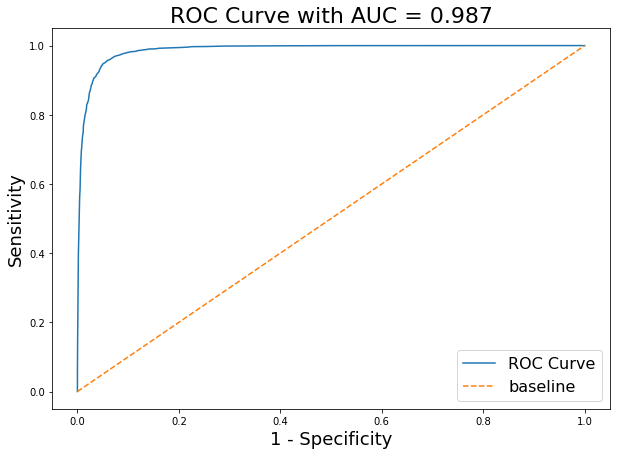

In [39]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

# source Matt Brems - lesson 4.04 

The ROC AUC score is .987 suggesting that when we are classifying a post into the science category we are right in our predictions 98.7% of the time. 

#### Residual Models
*models created for the purpose of hypertuning*

In [83]:
# TfidfVectorizer - max_features = 1100, C = 1.85
gridsearch(TfidfVectorizer(), LogisticRegression())

TfidfVectorizer

Best model: Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=1100,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.85, class_weight=None, dual=False,
                  

In [78]:
# TfidfVectorizer, LogisticRegression

gridsearch(TfidfVectorizer(), LogisticRegression())

TfidfVectorizer

Best model: Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=2000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.85, class_weight=None, dual=False,
                  

In [87]:
# gridsearch - TfidfVectorizer - max_features = 5000, C = 1.85
gridsearch(TfidfVectorizer(), LogisticRegression())

TfidfVectorizer

Best model: Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=5000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.85, class_weight=None, dual=False,
                  

In [91]:
# gridsearch - TfidfVectorizer - max_features = 10_000
gridsearch(TfidfVectorizer(), LogisticRegression())

TfidfVectorizer

Best model: Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=10000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.85, class_weight=None, dual=False,
                 

In [95]:
# gridsearch - TfidfVectorizer - max_features = 20_000 
gridsearch(TfidfVectorizer(), LogisticRegression())

/Users/bibor/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


TfidfVectorizer

Best model: Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=20000,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.85, class_weight=None, dual=False,
                 

In [79]:
gridsearch(CountVectorizer(), LogisticRegression())

/Users/bibor/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


CountVectorizer

Best model: Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=2000, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logisticregression',
                 LogisticRegression(C=1.7, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    mult